This notebook is about analysis of the data and the motivation for the upcoming models

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout2d,Flatten
from torch.optim import Adam, SGD
from tqdm import tqdm
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
from skimage.transform import rotate, AffineTransform, warp
import skimage.io as io
import ctypes
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
import seaborn as sns
from time import sleep
from random import random
np.set_printoptions(threshold=np.inf)
sns.set()

The listed below three files can be generated using instructions given at https://github.com/guillaumefrd/brain-tumor-mri-dataset Just make the default size of the image 128x128. <br>
images.npy contains list of 3064 brain MRI images.<br>
labels.npy contains the corresponding class.<br>
masks.npy is a boolean 2-D array specifying the region in the image that contains the tumour


In [2]:
labels = np.load('brain_tumor_dataset/labels.npy')
images = np.load('brain_tumor_dataset/images.npy')
masks = np.load('brain_tumor_dataset/masks.npy')

In [3]:
print('Shape of image is',images.shape)
#3064 images are  present of the shape 128x128

Shape of image is (3064, 128, 128)


bb_size computes the width and height of the bounding box of the tumour cell

In [4]:
def bb_size(img):
    r_min = 1000
    r_max = -1
    c_min = 1000
    c_max = -1
    for r in range(128):
        for c in range(128):
            if img[r][c]==True:
                if r_min>r:
                    r_min = r
                if r_max<r:
                    r_max = r
                if c_min > c:
                    c_min = c
                if c_max < c:
                    c_max = c
    return r_max-r_min, c_max-c_min
r_w = []
c_w = []
for i in tqdm(range(3064)):
    rw,cw = bb_size(masks[i,:,:])
    r_w.append(rw)
    c_w.append(cw)
area_mask=[]
for i in range(3064):
    area_mask.append(r_w[i]*c_w[i])

100%|██████████| 3064/3064 [00:48<00:00, 62.85it/s]


In [5]:
area_mask = sorted(area_mask)
area_mask = area_mask[:-5]
x = sorted(area_mask)
x[::-1]

[2025,
 2015,
 1960,
 1892,
 1880,
 1872,
 1845,
 1824,
 1806,
 1806,
 1802,
 1798,
 1785,
 1764,
 1760,
 1720,
 1677,
 1674,
 1650,
 1650,
 1640,
 1638,
 1638,
 1596,
 1591,
 1568,
 1568,
 1560,
 1558,
 1540,
 1539,
 1520,
 1518,
 1512,
 1512,
 1504,
 1482,
 1440,
 1440,
 1435,
 1428,
 1419,
 1408,
 1408,
 1404,
 1386,
 1376,
 1368,
 1368,
 1364,
 1363,
 1360,
 1360,
 1344,
 1344,
 1334,
 1330,
 1330,
 1330,
 1320,
 1320,
 1316,
 1302,
 1296,
 1295,
 1292,
 1292,
 1288,
 1287,
 1280,
 1280,
 1260,
 1254,
 1254,
 1254,
 1254,
 1248,
 1248,
 1247,
 1242,
 1240,
 1240,
 1240,
 1232,
 1230,
 1224,
 1224,
 1221,
 1216,
 1215,
 1209,
 1204,
 1200,
 1190,
 1189,
 1188,
 1188,
 1188,
 1188,
 1184,
 1184,
 1178,
 1178,
 1178,
 1178,
 1176,
 1173,
 1170,
 1170,
 1170,
 1170,
 1170,
 1170,
 1170,
 1161,
 1161,
 1156,
 1155,
 1155,
 1152,
 1152,
 1152,
 1148,
 1147,
 1140,
 1140,
 1134,
 1125,
 1122,
 1122,
 1122,
 1120,
 1120,
 1120,
 1120,
 1118,
 1116,
 1116,
 1116,
 1110,
 1110,
 1107,
 1102,

No handles with labels found to put in legend.


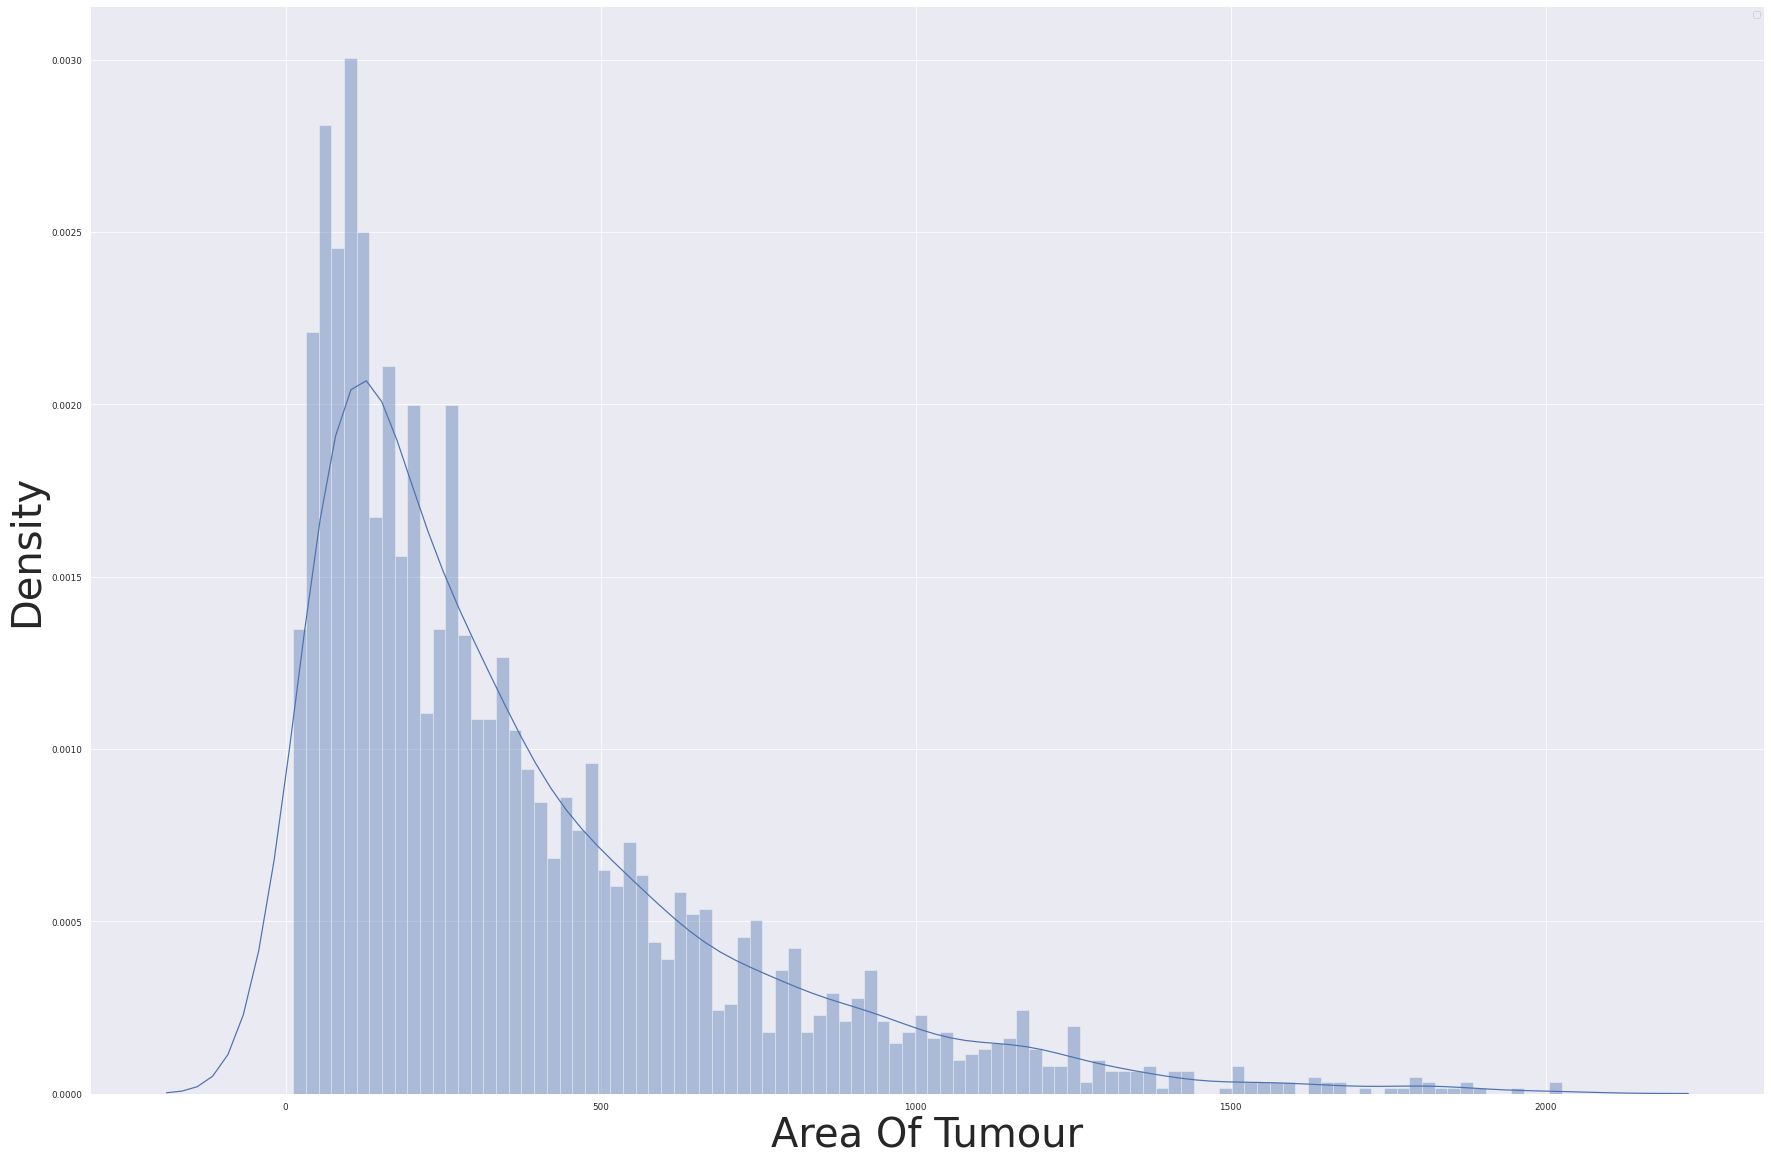

In [6]:
r_w.sort()
c_w.sort()

'''print("row width",np.mean(r_w), "std", np.std(r_w))
print("col width",np.mean(c_w), "std", np.std(c_w))
plt.figure(figsize=(16,9)) # figure ration 16:9
sns.set()
sns.distplot(c_w, label = "coloumn width",bins=200)
sns.distplot(r_w, label = "row width",bins=200)
plt.legend()
'''
sns.set_context("paper", rc={"font.size":800,"axes.titlesize":80,"axes.labelsize":50})   

fig = plt.figure(figsize=(30, 20))
sns.distplot(area_mask,bins=100)
plt.ylabel('Density',fontsize = 40)
plt.xlabel('Area Of Tumour',fontsize = 40)
plt.legend()


We can observe the both the width and height of the bounding box is less than 50 (ignoring the outliers)

Through above analysis we can see that the length and breadth of the filter follows approximately normal distribution
When solving classification problem using CNN the main content present in the training image should be the object which is to be identified. But in this dataset only a small part of MRI image is tumour. Average area of tumour cell is 8<sup>2</sup> and the area of image is 128<sup>2</sup> which is 4% only. So we have huge amount of non-essential information for classification. So, my idea is to extract the cancel cell from images to make a dataset and then make a model on top of it. Since the largest size of bounding box is 50. We train our initial model on 50x50 images.

# Now we will make a dataset for out model
For this process 50x50 image is convulated through the 128x128 image. If the 50x50 image contains the full cancer cell(l) we add the image and label(l). Otherwise, we add the image and label(0) corresponding to no cancer cell.

image a [[100, 29, 50, 70], [50, 99, 69, 190], [230, 0, 255, 70], [201, 103, 203, 101]] 
image b [[99, 69, 190], [0, 255, 70], [103, 203, 101]]


(-0.5, 2.5, 2.5, -0.5)

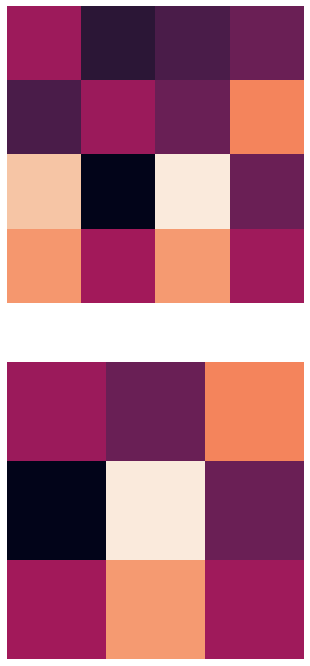

In [7]:
# given row, coloumn and size copy_image crops the orignal image and returns the cropped image 
def copy_image(img, r,c,filter_size):
    new_img = []
    temp = 0
    for temp in range(filter_size):
        new_img.append(img[r+temp][c:c+filter_size])
    return new_img
a = [[100,29,50,70],[50,99,69,190],[230,0,255,70],[201,103,203,101]]
b = copy_image(a, 1, 1,3)  # row = 2 col = 1 size = 2 **numbering starts from 0
print('image a',a, '\nimage b',b)
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2,1,1)
ax1.imshow(a)
plt.axis('off')
ax1 = fig.add_subplot(2,1,2)
ax1.imshow(b)
plt.axis('off')

(2, 1, 1, 0)


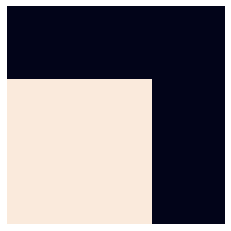

In [8]:
# bb_Size returns the row and coloumn number where the masks starts and ends  **indexing from 0
def bb_size(mask):
    r_min = 200
    r_max = -1
    c_min = 200
    c_max = -1
    n = mask.shape[0]
    for r in range(n):
        for c in range(n):
            if mask[r][c]==True:
                if r_min>r:
                    r_min = r
                if r_max<r:
                    r_max = r
                if c_min > c:
                    c_min = c
                if c_max < c:
                    c_max = c
    return r_max,r_min, c_max,c_min
mask = np.array([[False,False,False], [True, True,False],[True,True,False]])
plt.imshow(mask.astype(int))
plt.axis('off')
print(bb_size(mask))

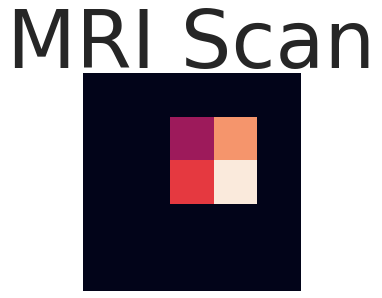

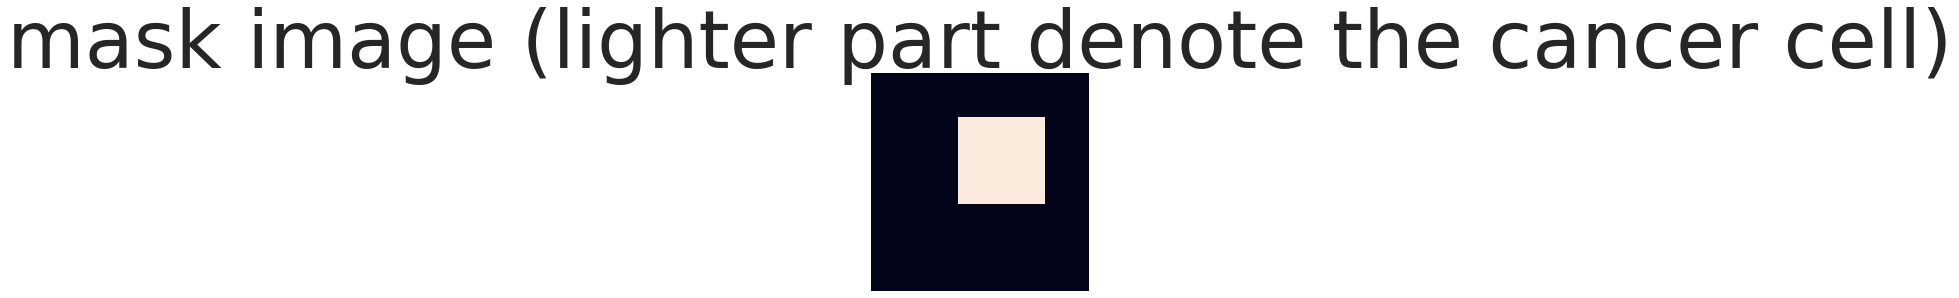

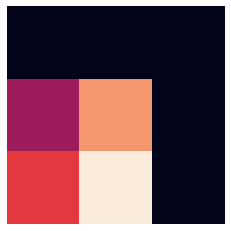

In [9]:
def add_datapoint(X,Y,img,mask,label, filter_size,prob_thres):
    r_ma,r_mi, c_ma,c_mi = bb_size(mask)
    area_of_cancer = (r_ma-r_mi)*(c_ma-c_mi)
    area_of_image = (filter_size)**2
    #if area_of_cancer/area_of_image < 0.05:
    #    return
    if(r_ma-r_mi>filter_size or c_ma-c_mi>filter_size):
        return;
    for i in range(0,img.shape[0] - filter_size+1,2):
        for j in range(0,img.shape[0]-filter_size+1,2):
            a = i
            b = i+filter_size
            c = j
            d = j+filter_size
            if a<=r_mi and b>r_ma and c<=c_mi and d>c_ma and abs((r_mi-a)-(b-r_ma))<15 and abs((c_mi-c)-(d-c_ma))<15:
                X.append(copy_image(img, i,j, filter_size))
                Y.append(label)
            else:
                prob = random()
                if prob<prob_thres:
                    X.append(copy_image(img, i,j, filter_size))
                    Y.append(0)
im = np.array([[0,0,0,0,0],[0,0,100,200,0],[0,0,150,255,0],[0,0,0,0,0],[0,0,0,0,0]])
mas = np.array([[False,False,False,False,False],[False,False,True,True,False],[False,False,True,True,False],[False,False,False,False,False],[False,False,False,False,False]])
x=[]
y=[]
lab = 2
fs = 3
add_datapoint(x,y,img=im,mask=mas,label=lab,filter_size=fs, prob_thres=0)
plt.imshow(im)
plt.title('MRI Scan')
plt.axis('off')
plt.show()
plt.imshow(mas.astype(int))
plt.title('mask image (lighter part denote the cancer cell)')
plt.axis('off')
plt.show()
for i in range(len(x)):
    plt.imshow(x[i])
    plt.axis('off')
    plt.show()

In [10]:
n  = masks.shape[0]
def make_dataset(images, masks, labels, filter_size = 50,prob_thres=0.001):
    X = []
    Y = []
    for i in tqdm(range(n)):
        add_datapoint(X,Y,images[i], masks[i],labels[i], filter_size,prob_thres)
    np.save("X_"+str(filter_size),X)
    np.save("Y_"+str(filter_size),Y)
#uncomment to see the above code working
'''n = 20
make_dataset(images, masks,labels,filter_size=20,prob_thres=0.002)
x = np.load("X_20.npy")
y = np.load("Y_20.npy")
print(x.shape, y.shape)
for i in range(x.shape[0]):
    plt.title(y[i])
    plt.imshow(x[i])
    plt.axis('off')
    plt.show()'''

'n = 20\nmake_dataset(images, masks,labels,filter_size=20,prob_thres=0.002)\nx = np.load("X_20.npy")\ny = np.load("Y_20.npy")\nprint(x.shape, y.shape)\nfor i in range(x.shape[0]):\n    plt.title(y[i])\n    plt.imshow(x[i])\n    plt.axis(\'off\')\n    plt.show()'

In [11]:
# make dataset for 50x50 image
make_dataset(images, masks,labels,filter_size=50,prob_thres=0.04)

100%|██████████| 3064/3064 [00:57<00:00, 53.51it/s]
